**Name**: Jyothi Priyanka Yerra

#### Importing Libraries and Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

In [2]:
data = pd.read_csv("healthcare-dataset-stroke-data.csv")
df = data.copy()
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [3]:
# drop ID field which is not necessary

df.drop(["id"], axis = 1, inplace = True)
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


# Exploratory Data Analysis

#### **Exploring initial data details per column**

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB


#### **Exploring the categorical data fields**

In [5]:
df.describe(exclude = ['float', 'int64'])

,gender,ever_married,work_type,Residence_type,smoking_status
count,5110,5110,5110,5110,5110
unique,3,2,5,2,4
top,Female,Yes,Private,Urban,never smoked
freq,2994,3353,2925,2596,1892


#### **Checking for null values in each column**

In [6]:
df.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

##### **Identified issue:** There are 201 missing BMI values.

##### **Solution:** We need to handle the missing data with either "model prediction" or "statistical substituitions".

#### **Setting colors and labels for all the graphs below**

In [7]:
stroke_pred_colors = ["#11BBAC","#DF1866"]
stroke_pred_legends = ["Non-Stroke", "Stroke"]

#### **Checking the distribution of dataset**

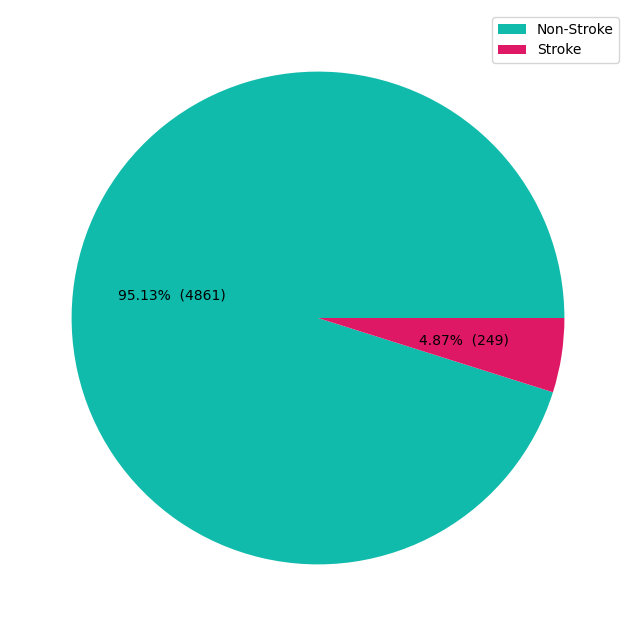

In [8]:
classes = df["stroke"].value_counts().index
class_counts = df["stroke"].value_counts()
def make_autopct(class_counts):
    def my_autopct(pct):
        total = sum(class_counts)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct

plt.figure(figsize=(8,8))
plt.pie(class_counts, autopct=make_autopct(class_counts), colors=stroke_pred_colors)
plt.legend(stroke_pred_legends, loc="best")
plt.show()

##### **Identified issue:** The data is highly imbalanced i.e., ~95% with non-stroke and ~5% with stroke. So any model predicting non-stroke for every individual will reach an accuracy of 95%.

##### **Solutions:** During modeling training, we need to perform either over sampling or under sampling to obtain best results.

#### **Identifying Stroke Risk per category (through plots)**

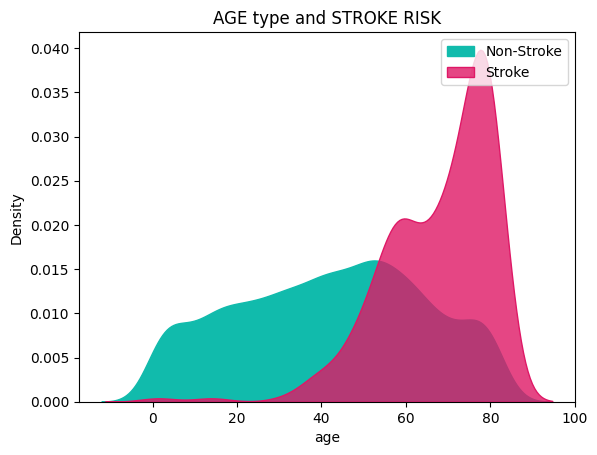

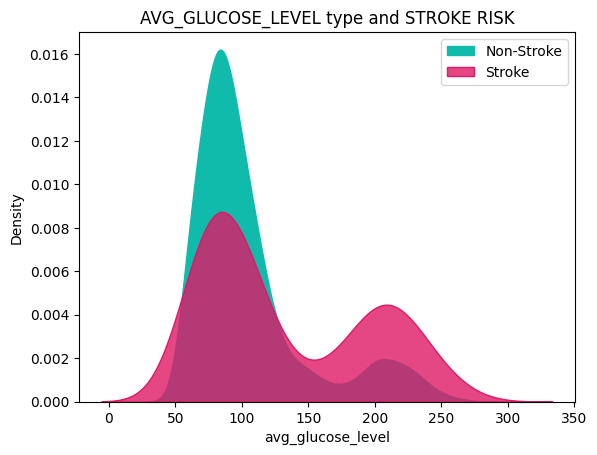

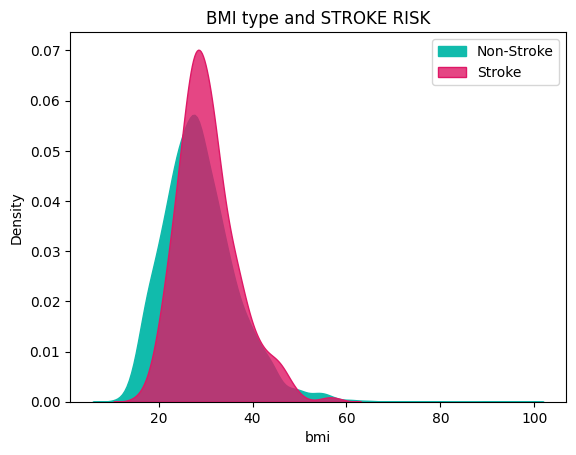

In [9]:
for column in df.columns[:-1]: # excluding stroke
  if df[column].dtype == 'float64':
    sns.kdeplot(data = df[df['stroke'] == 0], x = column, fill = True,  alpha = 1, color = stroke_pred_colors[0])
    sns.kdeplot(data = df[df['stroke'] == 1], x = column, fill = True,  alpha = 0.8, color = stroke_pred_colors[1])
    plt.title(f'{column.upper()} type and STROKE RISK')
    plt.legend(stroke_pred_legends, loc="best")
    plt.show()

In [10]:
import json

data_for_plots = {
    'density_plot': {
        'age': list(df['age']),
        'avg_glucose_level': list(df['avg_glucose_level']),
        'bmi': list(df['bmi']),
        'stroke': list(df['stroke'])
    },
    'bar_plot': {}
}

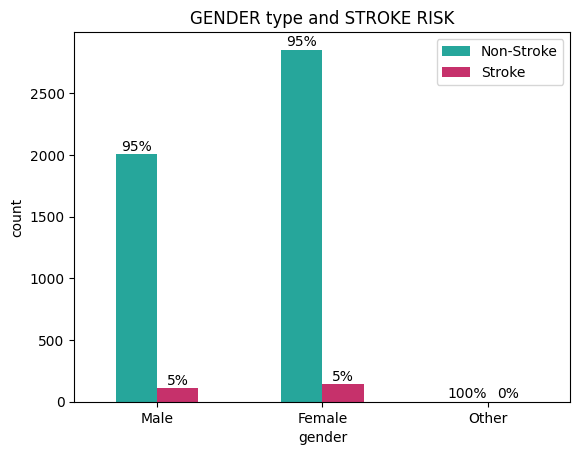

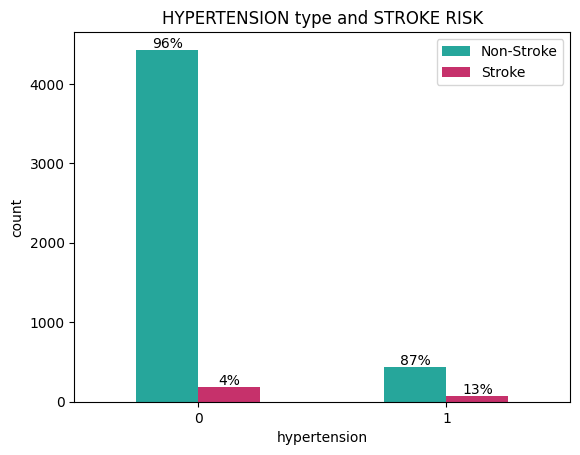

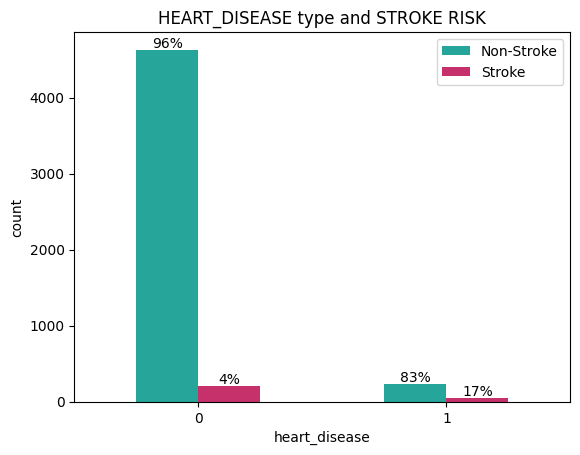

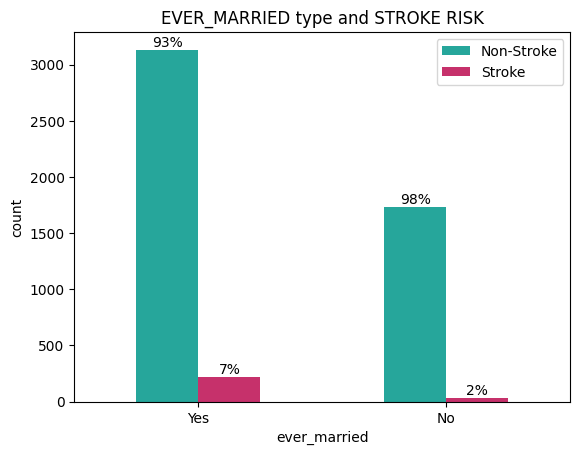

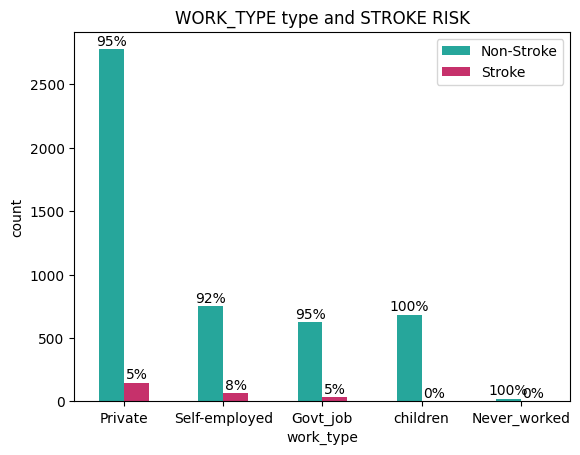

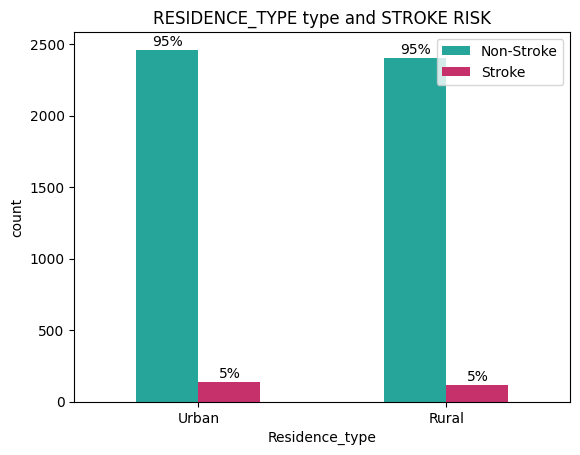

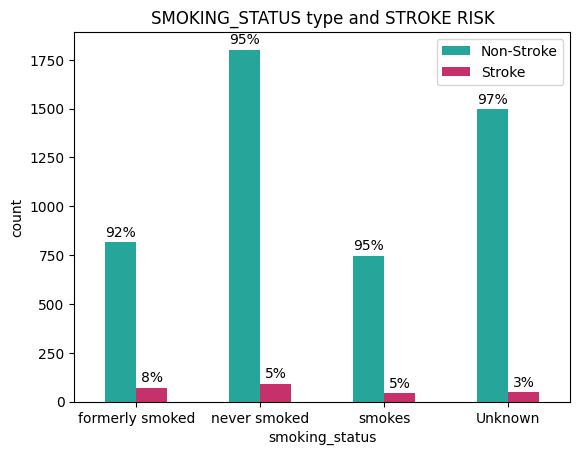

In [11]:
for column in df.columns[:-1]:   # excluding stroke
  if (df[column].dtype == 'object') or (df[column].dtype == 'int64'):
    #### for file
    data_for_plots['bar_plot'][column] = {}
    values = []
    ####
    ax = sns.countplot(data = df, x = column, fill = True, hue = 'stroke', width=0.5, palette = stroke_pred_colors) 
    bars = ax.patches
    no_bars_per_class = int(len(bars)/2)
    left_bars = bars[:no_bars_per_class]
    right_bars = bars[no_bars_per_class:]
    top_pad = 30
    for left, right in zip(left_bars, right_bars):
        non_stroke = left.get_height()
        stroke = right.get_height()
        total = non_stroke + stroke
        non_stroke_per = '{0:.0%}'.format(non_stroke/total)
        stroke_per = '{0:.0%}'.format(stroke/total)
        ax.text(left.get_x() + left.get_width()/2., non_stroke + top_pad, non_stroke_per, ha="center")
        ax.text(right.get_x() + right.get_width()/2., stroke + top_pad, stroke_per, ha="center")
        
        ####
        values.append({'non_stroke_count': non_stroke, 
                  'stroke_count': stroke,
                  'non_stroke_per': non_stroke_per,
                  'stroke_per': stroke_per})
    
    for label, value in zip(ax.get_xticklabels(), values):
      data_for_plots['bar_plot'][column][label.get_text()] = value
    ####
    
    plt.title(f'{column.upper()} type and STROKE RISK')
    plt.legend(stroke_pred_legends, loc="best")
    plt.show()

In [12]:
with open('population_level_data.json', 'w') as json_file:
    json.dump(data_for_plots, json_file)

# **Data Pre-processing**

#### **Encoding Category Labels**

In [13]:
# encode category values

dummies_gender = pd.get_dummies(df.gender,prefix="gender")
dummies_hypertension = pd.get_dummies(df.hypertension,prefix="hypertension")
dummies_heart_disease = pd.get_dummies(df.heart_disease,prefix="heart_disease")

dummies_ever_married = pd.get_dummies(df.ever_married,prefix="ever_married")
dummies_work_type = pd.get_dummies(df.work_type,prefix="work_type")
dummies_Residence_type = pd.get_dummies(df.Residence_type,prefix="Residence_type")
dummies_smoking_status = pd.get_dummies(df.smoking_status,prefix="smoking_status")

df = df.drop(['gender','hypertension', 'heart_disease','ever_married','work_type','Residence_type','smoking_status'],axis='columns')
df = pd.concat([df,dummies_hypertension, dummies_heart_disease, dummies_gender,dummies_ever_married,dummies_work_type,dummies_Residence_type,dummies_smoking_status],axis='columns')
df = df.drop(['gender_Other'],axis='columns')
df.head()

,age,avg_glucose_level,bmi,stroke,hypertension_0,hypertension_1,heart_disease_0,heart_disease_1,gender_Female,gender_Male,...,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,228.69,36.6,1,1,0,0,1,0,1,...,0,1,0,0,0,1,0,1,0,0
1,61.0,202.21,NaN,1,1,0,1,0,1,0,...,0,0,1,0,1,0,0,0,1,0
2,80.0,105.92,32.5,1,1,0,0,1,0,1,...,0,1,0,0,1,0,0,0,1,0
3,49.0,171.23,34.4,1,1,0,1,0,1,0,...,0,1,0,0,0,1,0,0,0,1
4,79.0,174.12,24.0,1,0,1,1,0,1,0,...,0,0,1,0,1,0,0,0,1,0


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 23 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   age                             5110 non-null   float64
 1   avg_glucose_level               5110 non-null   float64
 2   bmi                             4909 non-null   float64
 3   stroke                          5110 non-null   int64  
 4   hypertension_0                  5110 non-null   uint8  
 5   hypertension_1                  5110 non-null   uint8  
 6   heart_disease_0                 5110 non-null   uint8  
 7   heart_disease_1                 5110 non-null   uint8  
 8   gender_Female                   5110 non-null   uint8  
 9   gender_Male                     5110 non-null   uint8  
 10  ever_married_No                 5110 non-null   uint8  
 11  ever_married_Yes                5110 non-null   uint8  
 12  work_type_Govt_job              51

#### **Split the data into train and test datasets**

In [15]:
X = df.drop(['stroke'],axis='columns').values
y = df.stroke.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.10, shuffle=True, random_state = 1, stratify=y)

print("**** Train Data ****")
print(f"Total: {len(y_train)}")
print(f"#Stroke: {len(y_train[np.where(y_train==1)])}")
print(f"#Non-Stroke: {len(y_train[np.where(y_train==0)])}")

print("\n")
print("****** Test Data *****")
print(f"Total: {len(y_test)}")
print(f"#Stroke: {len(y_train[np.where(y_test==1)])}")
print(f"#Non-Stroke: {len(y_train[np.where(y_test==0)])}")

**** Train Data ****
Total: 4599
#Stroke: 224
#Non-Stroke: 4375


****** Test Data *****
Total: 511
#Stroke: 25
#Non-Stroke: 486


#### **Handling missing BMI values using KNNImputer**

In [16]:
imputer = KNNImputer(n_neighbors=5)
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

#### **Handling imbalanced dataset using Oversampling (SMOTE)**

In [17]:
print("**** Train Data Before Oversampling ****")
print(f"Total: {len(y_train)}")
print(f"#Stroke: {len(y_train[np.where(y_train==1)])}")
print(f"#Non-Stroke: {len(y_train[np.where(y_train==0)])}")

oversample = SMOTE(random_state=42)
X_train, y_train = oversample.fit_resample(X_train, y_train.ravel())

print("**** Train Data After Oversampling ****")
print(f"Total: {len(y_train)}")
print(f"#Stroke: {len(y_train[np.where(y_train==1)])}")
print(f"#Non-Stroke: {len(y_train[np.where(y_train==0)])}")

**** Train Data Before Oversampling ****
Total: 4599
#Stroke: 224
#Non-Stroke: 4375
**** Train Data After Oversampling ****
Total: 8750
#Stroke: 4375
#Non-Stroke: 4375


# **Training Using KNN**

In [18]:
sc = StandardScaler()
column_transformer = ColumnTransformer(transformers=[("sc", sc,[0,1,2])],remainder='passthrough')

In [19]:
pipe = Pipeline(steps=[('column_transformer', column_transformer),
                           ('knn', KNeighborsClassifier())])
    
obj = GridSearchCV(pipe,{
    'knn__weights':['uniform','distance'],
    'knn__n_neighbors': range(2,10),
    'knn__metric':['euclidean','manhattan']
}, cv=10,return_train_score=False)

obj.fit(column_transformer.fit_transform(X_train), y_train)
print(obj.best_params_)

{'knn__metric': 'manhattan', 'knn__n_neighbors': 2, 'knn__weights': 'uniform'}


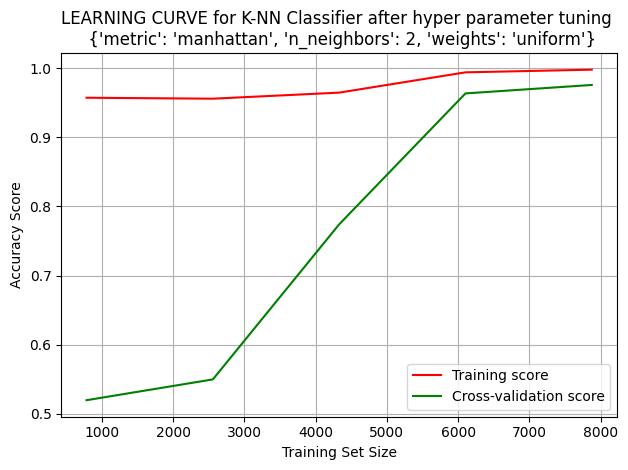

In [20]:
# learning curve after hyper parameter tuning
pipe = Pipeline(steps=[('column_transformer', column_transformer),
                           ('knn', KNeighborsClassifier(n_neighbors=2,weights='uniform',metric='manhattan'))])
sizes, training_scores, validation_scores = learning_curve(pipe, X_train, y_train, cv=10, scoring='accuracy')
mean_training_score = np.mean(training_scores, axis=1)
mean_validation_score = np.mean(validation_scores, axis=1)
plt.plot(sizes, mean_training_score, color="r",  label="Training score")
plt.plot(sizes, mean_validation_score, color="g", label="Cross-validation score")
# Drawing plot
plt.title("LEARNING CURVE for K-NN Classifier after hyper parameter tuning \n {'metric': 'manhattan', 'n_neighbors': 2, 'weights': 'uniform'}")
plt.xlabel("Training Set Size"), 
plt.ylabel("Accuracy Score"), 
plt.legend(loc="best")
plt.tight_layout()
plt.grid()
plt.show()

In [21]:
# checking the above, our parameters selected for this classifier are 

X_test_ovrsampl, y_test_oversampl = oversample.fit_resample(X_test, y_test.ravel())

knn_classifier = KNeighborsClassifier(n_neighbors=2,weights='uniform',metric='manhattan')
knn_classifier.fit(column_transformer.fit_transform(X_train), y_train)

y_train_predicted    = knn_classifier.predict(column_transformer.fit_transform(X_train))
train_accuracy       = accuracy_score(y_train,y_train_predicted)*100
train_conf_matrix    = confusion_matrix(y_train, y_train_predicted)
train_classif_report = classification_report(y_train, y_train_predicted)

y_test_predicted     = knn_classifier.predict(column_transformer.transform(X_test_ovrsampl))
test_accuracy        = accuracy_score(y_test_oversampl,y_test_predicted)*100
test_conf_matrix     = confusion_matrix(y_test_oversampl,y_test_predicted)
test_classif_report  = classification_report(y_test_oversampl,y_test_predicted)

print("****** Training ******")
print("Accuracy: ", train_accuracy)
print("Confusion Metrics: \n", train_conf_matrix)
print("Classification Report: \n", train_classif_report)

print("****** Testing ******")
print("Accuracy: ", test_accuracy)
print("Confusion Metrics: \n", test_conf_matrix)
print("Classification Report: \n", test_classif_report)

****** Training ******
Accuracy:  99.81714285714285
Confusion Metrics: 
 [[4375    0]
 [  16 4359]]
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      4375
           1       1.00      1.00      1.00      4375

    accuracy                           1.00      8750
   macro avg       1.00      1.00      1.00      8750
weighted avg       1.00      1.00      1.00      8750

****** Testing ******
Accuracy:  66.9753086419753
Confusion Metrics: 
 [[473  13]
 [308 178]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.61      0.97      0.75       486
           1       0.93      0.37      0.53       486

    accuracy                           0.67       972
   macro avg       0.77      0.67      0.64       972
weighted avg       0.77      0.67      0.64       972



(array([677.,   0.,   0.,   0.,   0., 104.,   0.,   0.,   0., 191.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

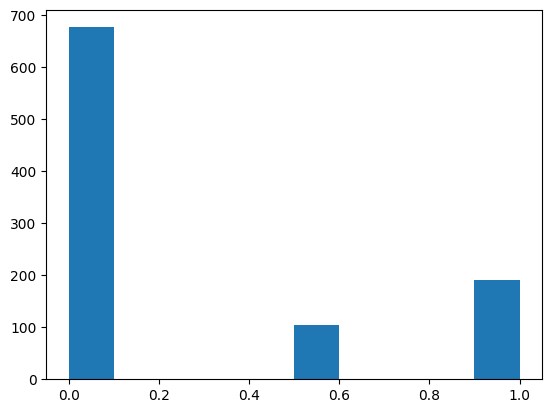

In [22]:
y_predict_prob = knn_classifier.predict_proba(column_transformer.transform(X_test_ovrsampl))[:,1]
plt.hist(y_predict_prob)